In [10]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt


In [11]:
env = make_vec_env("HalfCheetah-v4", n_envs=4)  # vectorized for speed


In [8]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_mujoco_tensorboard/")
model.learn(total_timesteps=500_000)  # adjust based on compute


Using cpu device
Logging to ./ppo_mujoco_tensorboard/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -378     |
| time/              |          |
|    fps             | 20083    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -354        |
| time/                   |             |
|    fps                  | 9517        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.009375431 |
|    clip_fraction        | 0.0896      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.46       |
|    explaine

In [4]:
ant_env = make_vec_env("Ant-v4", n_envs=4)
ant_model = PPO("MlpPolicy", ant_env, verbose=1)
ant_model.learn(total_timesteps=500_000)


/opt/miniconda3/envs/mujoco-env/lib/python3.10/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment Ant-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 142      |
|    ep_rew_mean     | -152     |
| time/              |          |
|    fps             | 6390     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 160        |
|    ep_rew_mean          | -169       |
| time/                   |            |
|    fps                  | 4702       |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.01229723 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.3      |
|    explained_variance   | -0.00954   |
|    learning_rate        | 

## reward eval

In [13]:
def evaluate_policy(model, env_name, n_episodes=5):
    env = gym.make(env_name)
    rewards = []
    for _ in range(n_episodes):
        obs, done = env.reset()
        total_reward = 0
        while True:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if terminated or truncated:
                break
        rewards.append(total_reward)
    return rewards

halfcheetah_rewards = evaluate_policy(model, "HalfCheetah-v4")
ant_rewards = evaluate_policy(ant_model, "Ant-v4")
print("HalfCheetah rewards:", halfcheetah_rewards)
print("Ant rewards:", ant_rewards)


HalfCheetah rewards: [np.float64(614.6502820279737), np.float64(602.8753800840209), np.float64(481.9551599037369), np.float64(680.8605215289111), np.float64(635.3245131763173)]
Ant rewards: [np.float64(20.077081795986857), np.float64(14.719828151975854), np.float64(-23.247131371739854), np.float64(61.57129321889797), np.float64(14.784233052041298)]


## PPO on Ant-v4

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.2     |
|    ep_rew_mean     | -101     |
| time/              |          |
|    fps             | 6449     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 118         |
|    ep_rew_mean          | -124        |
| time/                   |             |
|    fps                  | 4625        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.013706744 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.2       |
|    explained_variance   | -0.00436    |
|    learning

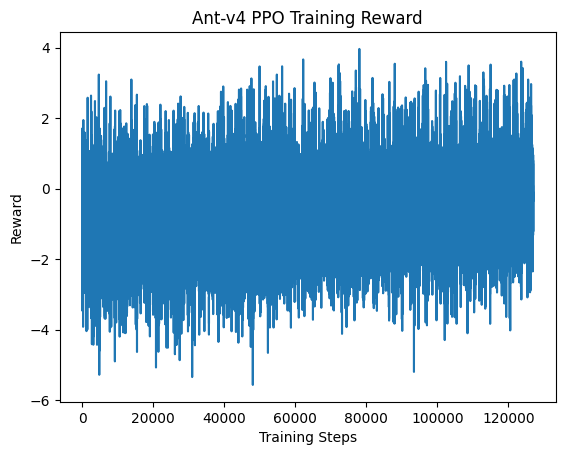

In [12]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardLoggerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.rewards = []

    def _on_step(self) -> bool:
        self.rewards.append(self.locals['rewards'][0])
        return True

callback = RewardLoggerCallback()
ant_model = PPO("MlpPolicy", ant_env, verbose=1)
ant_model.learn(total_timesteps=500_000, callback=callback)

plt.plot(callback.rewards)
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.title("Ant-v4 PPO Training Reward")
plt.show()


Ep rewards are negative (-101, -124):
This means your agent is still failing at the task (probably Ant-v4 or Humanoid-like envs, which start very hard). Early in training, it’s normal to see negative rewards.

Episode length (98 → 118):
The agent is surviving longer before failing, which might mean it’s starting to explore better.

Clip fraction ~0.145, KL ~0.013:
Both values are in a healthy range — PPO updates are stable and not diverging.

Entropy loss -11.2:
Still exploring a lot (good early on). Over time, entropy should drop as the agent converges.

Value loss ~39.9:
The value function is still learning and not very accurate yet, but this will stabilize with training.